In [21]:
import os
import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from models.position_encoding import PositionEmbeddingSine
from models.backbone import Backbone, Joiner
from models.transformer import Transformer
from models.detr import DETR
import util.misc as utils

from datasets.coco import CocoDetection_query, make_coco_transforms

In [2]:
device      = torch.device('cuda')
hidden_dim = 256
N_steps = 256 // 2
position_embedding = PositionEmbeddingSine(N_steps)
backbone = Backbone(name                 = 'resnet50',
                    train_backbone       = False,
                    return_interm_layers = False,
                    dilation             = False)
backbone_ = Joiner(backbone, position_embedding)
backbone_.num_channels = backbone.num_channels

transformer = Transformer(
        d_model=hidden_dim,
        dropout=0.1,
        nhead=8,
        dim_feedforward=2048,
        num_encoder_layers=6,
        num_decoder_layers=6,
        normalize_before=False,
        return_intermediate_dec=True,
    )


model = DETR(
    backbone_,
    transformer,
    num_classes = 11,
    num_queries = 100,
    aux_loss    = False,
)

checkpoint = torch.load('/home/ubuntu/detr/results/bdd_100k-day/checkpoint.pth', map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.to(device)


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
       

In [17]:
coco_path = '/home/ubuntu/admin_dataprep/external/bdd_100k-day/'
image_set = 'test'

prob = os.path.basename(os.path.dirname(coco_path))
img_folder = os.path.join(coco_path, f'{prob}_full', str(image_set.split('_')[0]))
ann_file = os.path.join(coco_path, 'labels_full', 'coco', f'coco_{image_set}.json')
dataset = CocoDetection_query(img_folder, ann_file, transforms=make_coco_transforms(image_set.split('_')[0]), return_masks=False)
sampler   = torch.utils.data.RandomSampler(dataset)
data_loader   = DataLoader(dataset,
                           1,
                           sampler      = sampler,
                           drop_last    = False,
                           collate_fn   = utils.collate_fn_query,
                           num_workers  = 2)


loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


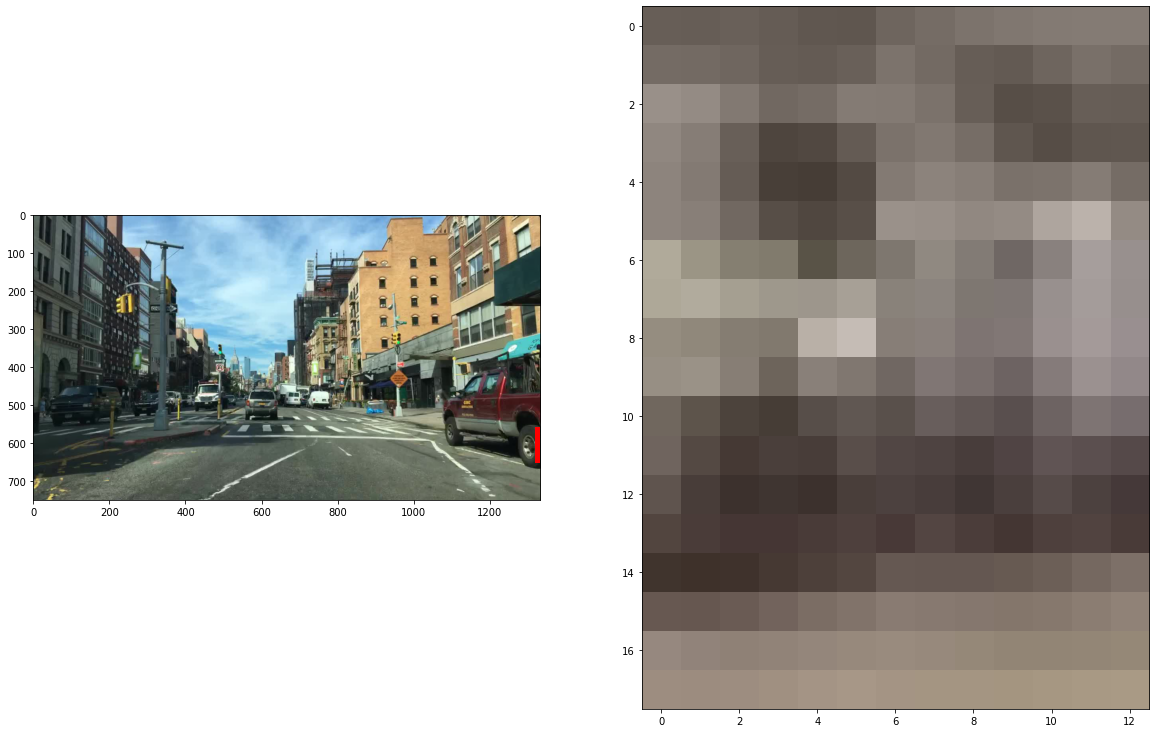

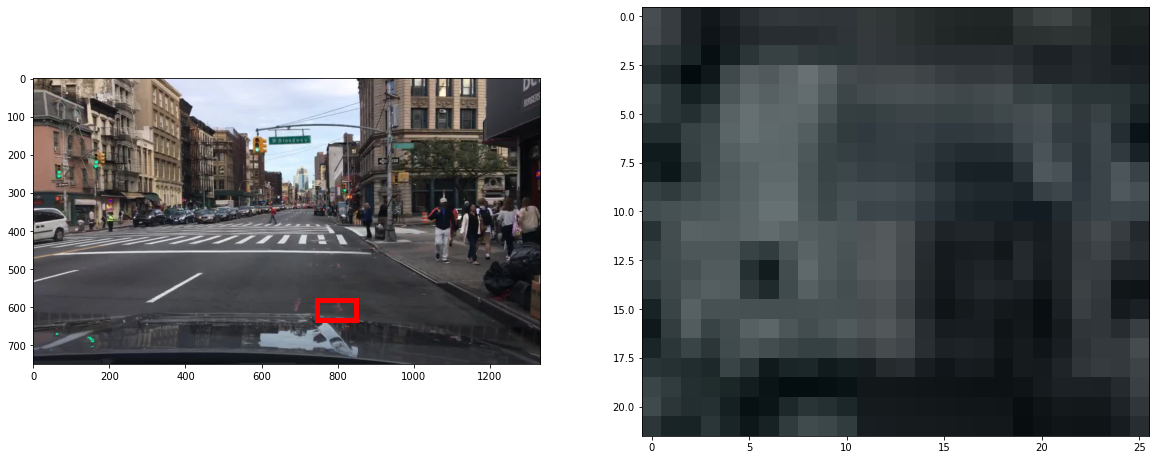

In [41]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
denorm = UnNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

for i, (img, gt, query) in enumerate(data_loader):
    model.eval()
    outputs = model(img.to(device), query.to(device))
    out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']
    prob = F.softmax(out_logits, -1)
    scores, labels = prob[..., :-1].max(-1)
    idx = scores.argsort().cpu().detach().numpy()[0][-1]
    bbox  = out['pred_boxes'][0][idx].cpu().detach().numpy()
    c,h,w = img.tensors[0].shape

    fig, ax = plt.subplots(1,2, figsize=(20,40))

    ax[0].imshow(denorm(img.tensors[0]).permute(1,2,0))
    ax[1].imshow(denorm(query.tensors[0]).permute(1,2,0))

    
    
    
    

    rect = patches.Rectangle((int(bbox[0]*w),
                              int(bbox[1]*h)),
                              bbox[2]*w,
                              bbox[3]*h,
                             linewidth=5,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax[0].add_patch(rect)
    if i == 1:
        break
